In [4]:
%matplotlib widget
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform, io, exposure

from pystackreg import StackReg
import pystackreg

print(pystackreg.__version__)

0.2.7


Define helper functions

In [5]:
def overlay_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = np.stack(imgs, axis=0)

    return aggregator(imgs, axis=0)

def composite_images(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

In [7]:
### Load left and right images
left_image = io.imread('stereo/images/cam01_modified.tif')
right_image = io.imread('stereo/images/cam02_modified.tif')

# left_image = io.imread('tests/images/cam01.tif')
# right_image = io.imread('tests/images/cam02.tif')

## Define the left image as the reference and the right image as the moving image
ref = left_image.astype(np.float64)
mov = right_image.astype(np.float64)

Perform single image registration

In [8]:
transformations = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

Show original images

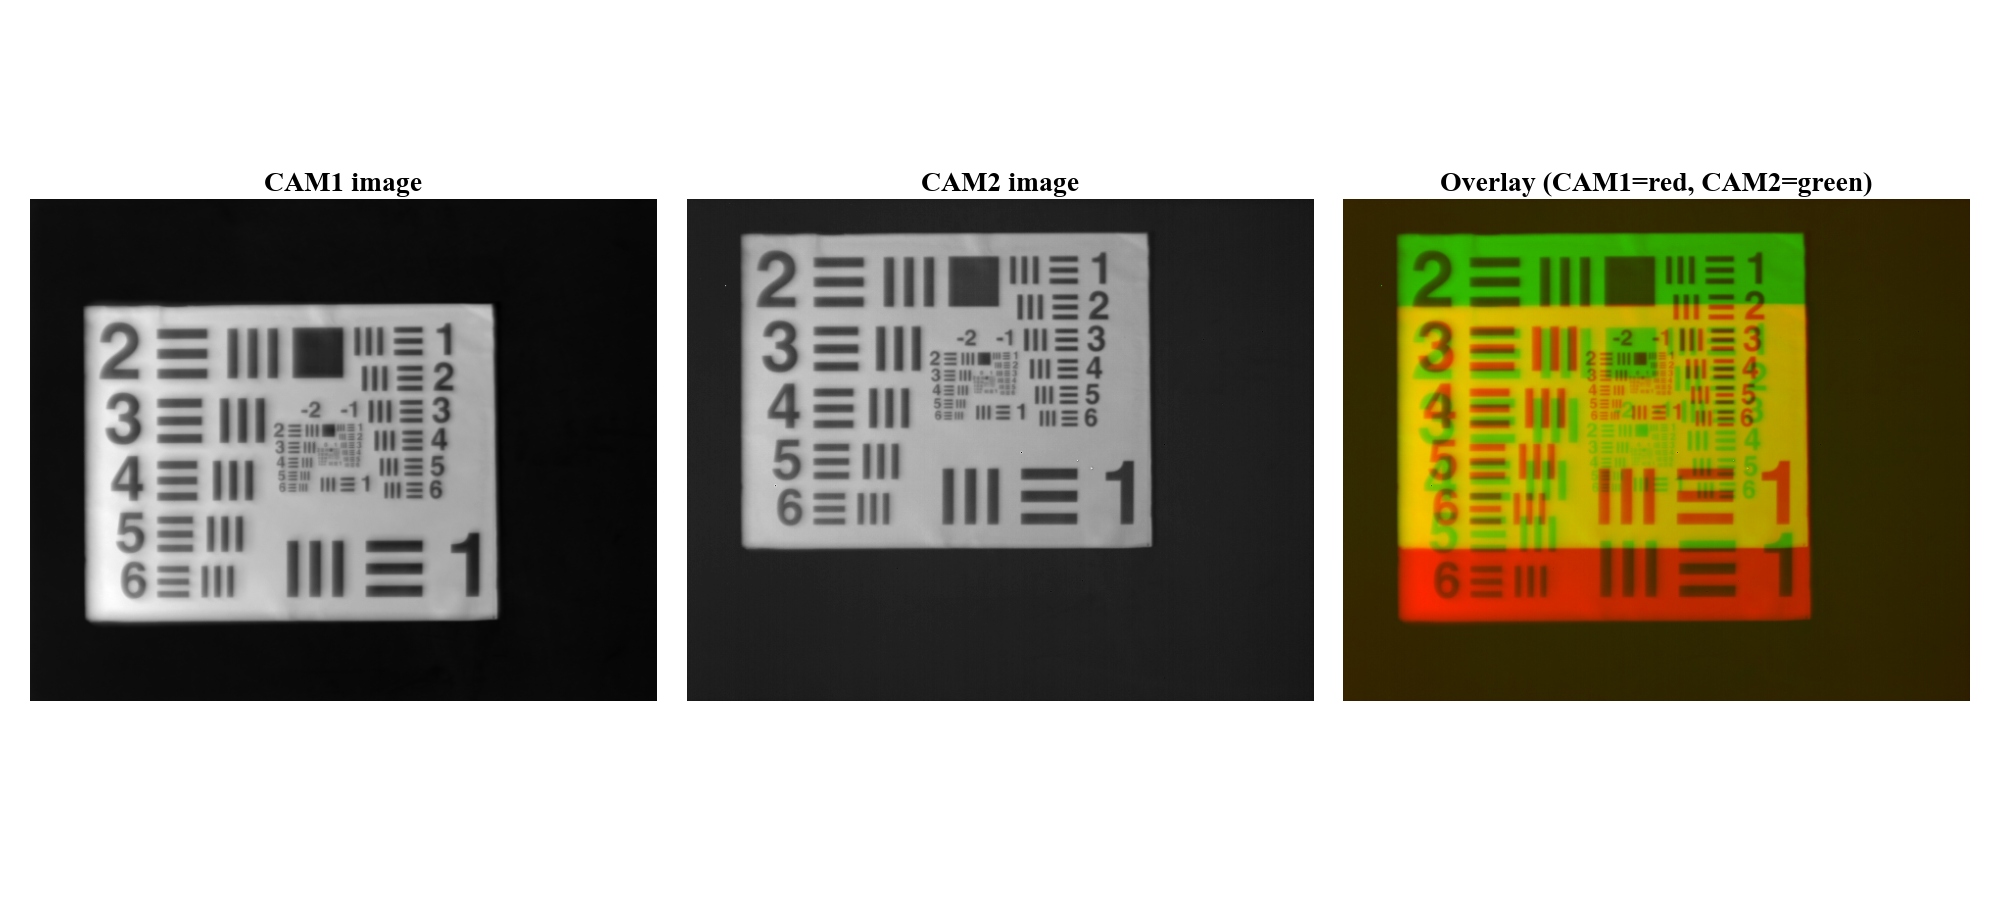

In [9]:
import matplotlib.pyplot as plt

# Set font properties
font = {'family': 'Times New Roman', 'size': 20, 'weight': 'bold'}
plt.rc('font', **font)

f, ax = plt.subplots(1, 3, figsize=(20, 9))

# Assuming `composite_images` is a function that returns the overlay image
before_reg = composite_images([ref, mov])

ax[0].imshow(ref, cmap='gray')
ax[0].set_title('CAM1 image', fontdict=font)  # Set title font properties
ax[0].axis('off')

ax[1].imshow(mov, cmap='gray')
ax[1].set_title('CAM2 image', fontdict=font)  # Set title font properties
ax[1].axis('off')

ax[2].imshow(before_reg)
ax[2].set_title('Overlay (CAM1=red, CAM2=green)', fontdict=font)  # Set title font properties
ax[2].axis('off')

plt.tight_layout()
plt.show()


Transform shifted image

In [10]:
def show_transformation(tmat, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    p = np.array([[1,120,1], [1,1,1], [250, 1, 1], [250,120,1], [1,120,1]])
    ax.plot(p[:, 0], p[:,1])
    q=np.dot(p, tmat.T)
    ax.plot(q[:, 0], q[:,1])
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.legend(['Original image', 'transformed image'])

[[  1.           0.          -1.57798247]
 [  0.           1.         -73.33348433]
 [  0.           0.           1.        ]]
[[ 9.99997609e-01 -2.18671937e-03 -1.00127654e+00]
 [ 2.18671937e-03  9.99997609e-01 -7.39088148e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.94418513e-01 -2.35072405e-03  5.85000109e-01]
 [ 2.35072405e-03  9.94418513e-01 -7.25433535e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.94182669e-01 -2.56771595e-03  7.02636834e-01]
 [ 2.28567365e-03  9.94657937e-01 -7.25872836e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.94225913e-01 -2.48284834e-03 -2.27864205e-07  6.88517181e-01]
 [ 1.59464245e-03  9.93914616e-01  2.80140774e-06 -7.24071463e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


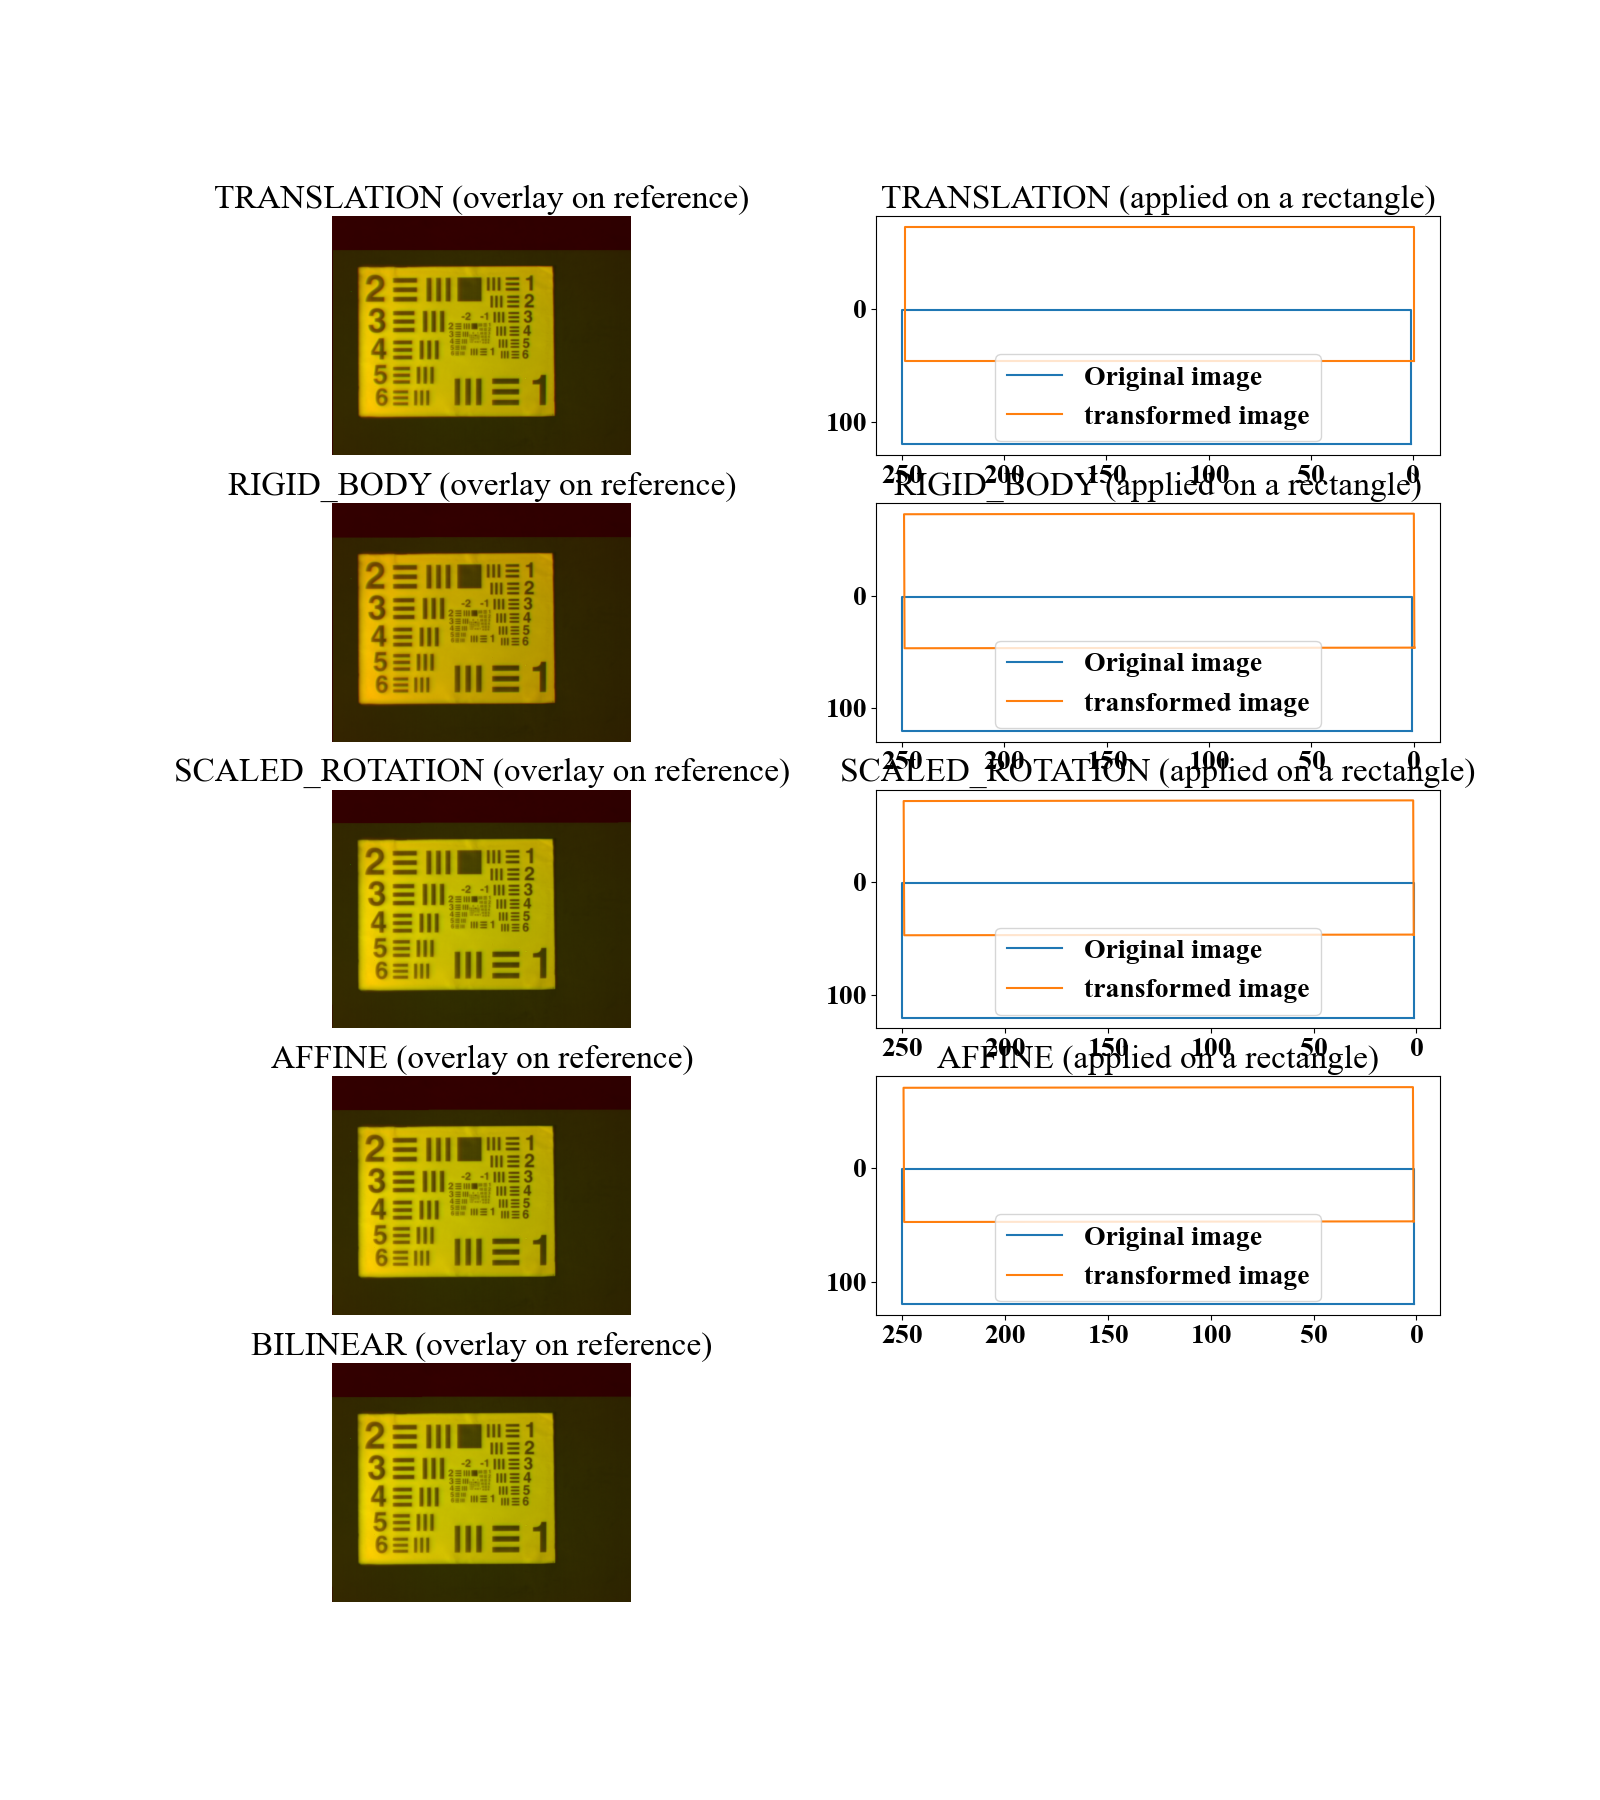

In [11]:
f, ax = plt.subplots(5, 2, figsize=(16, 18))

for i, (name, tf) in enumerate(transformations.items()):
    sr = StackReg(tf)
    
    reg = sr.register_transform(ref, mov)
    reg = reg.clip(min=0)

    print(sr.get_matrix())

    after_reg =  composite_images([ref, reg])

    ax[i][0].imshow(after_reg, cmap='gray', vmin=0, vmax=1)
    ax[i][0].set_title(name + ' (overlay on reference)')
    ax[i][0].axis('off')

    if name != 'BILINEAR':
        show_transformation(sr.get_matrix(), ax[i][1])
        ax[i][1].set_title(name + ' (applied on a rectangle)')
    else:
        ax[i][1].axis('off')

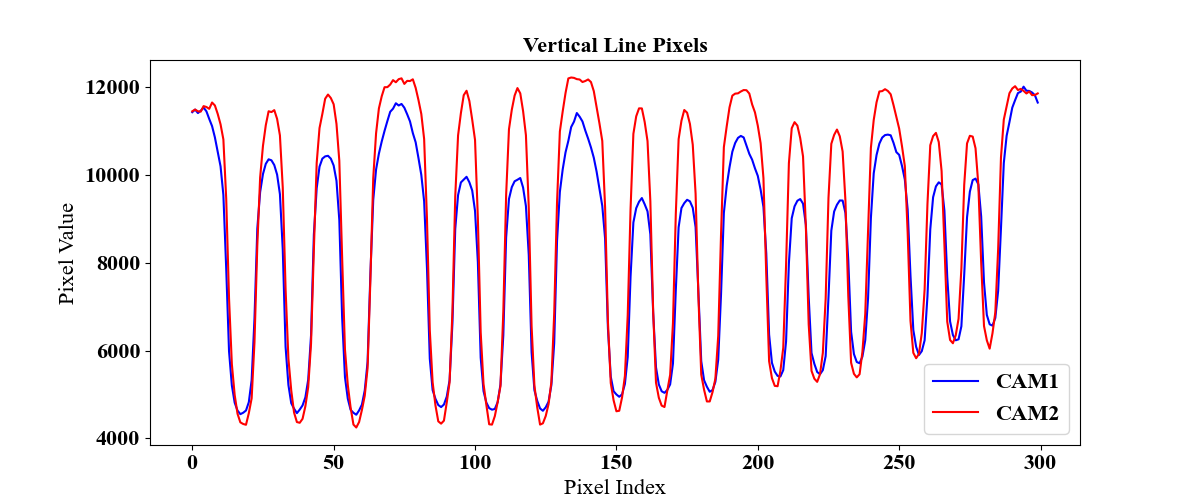

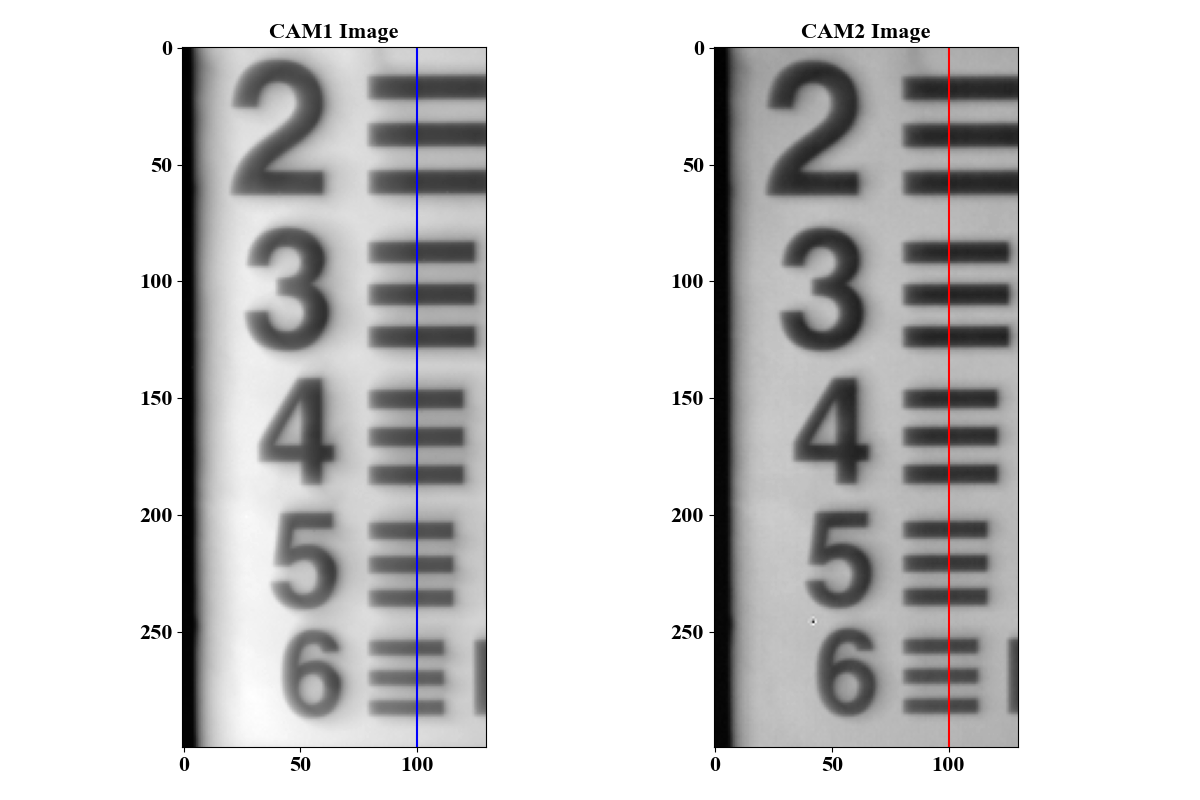

In [12]:
sr = StackReg(StackReg.RIGID_BODY)    
reg = sr.register_transform(ref, mov)

# Define the region of interest
roi_ref = ref[120:420,50:180]
roi_reg = reg[120:420,50:180]

# Extract the vertical line pixels at x=18
ref_line_pixels = roi_ref[:, 100]
reg_line_pixels = roi_reg[:, 100]

# Set font properties
font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
plt.rc('font', **font)

# Create the subplot for images
f1, ax1 = plt.subplots(1, 2, figsize=(12, 8))

# Plot the reference image
ax1[0].imshow(roi_ref, cmap='gray')
ax1[0].axvline(x=100, color='blue', linestyle='-')
ax1[0].set_title('CAM1 Image', fontdict=font)
# ax1[0].legend()

# Plot the registered image
ax1[1].imshow(roi_reg, cmap='gray')
ax1[1].axvline(x=100, color='red', linestyle='-')
ax1[1].set_title('CAM2 Image', fontdict=font)
# ax1[1].legend()

# Adjust layout for the first figure
plt.tight_layout()

# Set font properties
font = {'family': 'Times New Roman', 'size': 16,'weight':'bold'}
plt.rc('font', **font)

f, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the vertical line pixels for both images
delta = ref_line_pixels[1]-reg_line_pixels[1]
ax.plot(ref_line_pixels-delta, label='CAM1', color='blue')
ax.plot(reg_line_pixels, label='CAM2', color='red')
ax.set_title('Vertical Line Pixels', fontdict=font)
ax.set_xlabel('Pixel Index')
ax.set_ylabel('Pixel Value')
ax.legend()

plt.show()

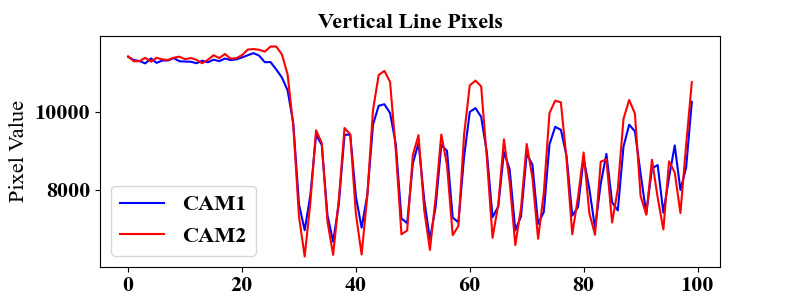

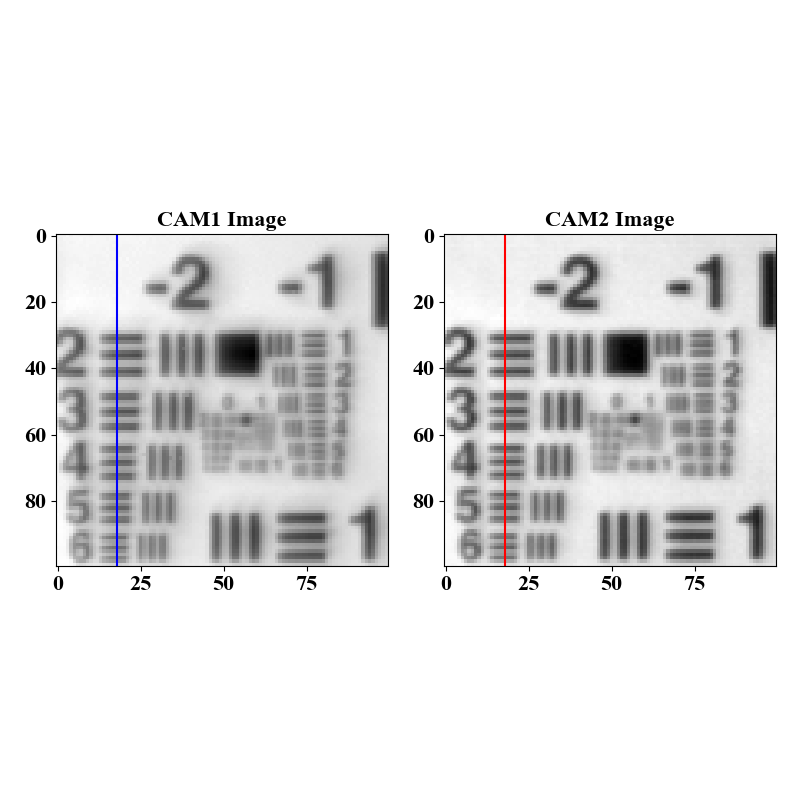

In [ ]:
sr = StackReg(StackReg.RIGID_BODY)    
reg = sr.register_transform(ref, mov)

# Define the region of interest
roi_ref = ref[200:300, 250:350]
roi_reg = reg[200:300, 250:350]

# Extract the vertical line pixels at x=18
ref_line_pixels = roi_ref[:, 18]
reg_line_pixels = roi_reg[:, 18]

# Set font properties
font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
plt.rc('font', **font)

# Create the subplot for images
f1, ax1 = plt.subplots(1, 2, figsize=(8, 8))

# Plot the reference image
ax1[0].imshow(roi_ref, cmap='gray')
ax1[0].axvline(x=18, color='blue', linestyle='-')
ax1[0].set_title('CAM1 Image', fontdict=font)
# ax1[0].legend()

# Plot the registered image
ax1[1].imshow(roi_reg, cmap='gray')
ax1[1].axvline(x=18, color='red', linestyle='-')
ax1[1].set_title('CAM2 Image', fontdict=font)
# ax1[1].legend()

# Adjust layout for the first figure
plt.tight_layout()

# Set font properties
font = {'family': 'Times New Roman', 'size': 16,'weight':'bold'}
plt.rc('font', **font)

f, ax = plt.subplots(1, 1, figsize=(8, 3))

# Plot the vertical line pixels for both images
ax.plot(ref_line_pixels, label='CAM1', color='blue')
ax.plot(reg_line_pixels, label='CAM2', color='red')
ax.set_title('Vertical Line Pixels', fontdict=font)
ax.set_xlabel('Pixel Index')
ax.set_ylabel('Pixel Value')
ax.legend()

plt.show()